In [1]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=10,20

c:\Users\yangs\.conda\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
path_1 = "../Data/original/train_2025.csv"

test_path = "../Data/original/test_2025.csv"

# 2. Load the data
train_df_25 = pd.read_csv(path_1) 

# df_train = pd.concat([train_df_23, train_df_25], ignore_index=True)
df_train = train_df_25

X_test = pd.read_csv(test_path)

In [22]:
test_claim_number = X_test['claim_number']

## pre-processing

In [23]:
def pre_processing(df, train = True):
    del df['claim_number']

    df.loc[df['age_of_driver']>75, 'age_of_driver'] = 75 

    df['claim_date']=pd.to_datetime(df['claim_date'])

    colnames_to_str = ['marital_status', 'high_education_ind', 'address_change_ind', 
                       'zip_code', 'witness_present_ind', 'policy_report_filed_ind']
    df[colnames_to_str] = df[colnames_to_str].astype(str)
    df['zip_code'] = df['zip_code'].str.zfill(5)

    # age of driver: before midlife, midlife (40-50), after midlife

    df['age_cat'] = ['before_mid' if x<40 else 
                          'mid' if 40<=x<50 else 
                          'after_mid' for x in df['age_of_driver']]

    # # week of the day: weekend, before/after weekend, midweek
    # df['dofw_cat'] = ['wkd' if x in ['Saturday', 'Sunday'] else 
    #                        'bfaf_wkd' if x in ['Monday', 'Friday'] else 
    #                        'mid_wk' for x in df['claim_day_of_week']]
    # del df['claim_day_of_week']

    ## zip code extraction
    df['zip_1'] = [x[0] for x in df['zip_code']] ## region
#     df['zip_123'] = [x[0:3] for x in df['zip_code']] ## county
    del df['zip_code']

    df['vhc_price_cat'] = ['under_20k' if x<20000  else 
                           'btw_20_30k' if 20000<=x<30000 else
                           'btw_30_40k' if 30000<=x<40000 else
                           'btw_40_50k' if 40000<=x<50000 else
                           'above_50k' for x in df['vehicle_price']]
    
    ## date extraction
    df['claim_year'] = df['claim_date'].dt.year
    df['claim_month'] = df['claim_date'].dt.month 
    # df['claim_day'] = df['claim_date'].dt.day 
    # global dt_fraudrate
    # if train:
    #     dt_fraudrate = df.groupby('claim_day')['fraud'].mean()
    del df['claim_date']
    # # freq = df['claim_day'].value_counts(normalize = True)
    
    # # print(dt_fraudrate)
    # high_frd_days = dt_fraudrate.index[dt_fraudrate>0.17].tolist()
    # los_frd_days = dt_fraudrate.index[dt_fraudrate<0.14].tolist()
    # df['day_fraud'] = ['high_fraud' if x in high_frd_days  else 
    #                        'low_fraud' if x in los_frd_days else
    #                        'mid_fraud' for x in df['claim_day']]
    
    # del df['claim_day']
    df[['claim_year', 'claim_month']] = df[['claim_year', 'claim_month']].astype(str)
    
    
    return df

In [24]:
train_df = pre_processing(df_train)
test_df = pre_processing(X_test)

In [25]:
input_cols = list(train_df.columns)
input_cols.remove('fraud')
target_col = 'fraud'

inputs = df_train[input_cols].copy()
target = df_train[target_col].copy()

X_train, X_valid, y_train, y_valid = train_test_split(inputs, target, test_size=0.1)

numeric_cols = X_train.select_dtypes(include=np.number, exclude=['datetime']).columns.tolist()
categorical_cols = X_train.select_dtypes(['object','datetime']).columns.tolist()

imputer = SimpleImputer(strategy = 'mean')
imputer.fit(df_train[numeric_cols])

X_train[numeric_cols] = imputer.transform(X_train[numeric_cols])
X_valid[numeric_cols] = imputer.transform(X_valid[numeric_cols])
X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])

scaler = MinMaxScaler()
scaler.fit(df_train[numeric_cols])

X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df_train[categorical_cols])


# Ensure you're transforming the same columns the encoder was fit on
input_cols = encoder.feature_names_in_
encoded_cols = list(encoder.get_feature_names_out(input_cols))

X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[input_cols]).toarray(),  # .toarray() if it's sparse
    columns=encoded_cols,
    index=X_train.index
)
X_valid_encoded = pd.DataFrame(
    encoder.transform(X_valid[input_cols]).toarray(),
    columns=encoded_cols,
    index=X_valid.index
)
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[input_cols]).toarray(),
    columns=encoded_cols,
    index=X_test.index
)

# Drop original categorical columns and merge encoded
X_train = pd.concat([X_train.drop(columns=input_cols), X_train_encoded], axis=1)
X_valid = pd.concat([X_valid.drop(columns=input_cols), X_valid_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=input_cols), X_test_encoded], axis=1)


X_train = X_train[numeric_cols+encoded_cols]
X_valid = X_valid[numeric_cols+encoded_cols]
X_test = X_test[numeric_cols+encoded_cols]


In [26]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

In [27]:
parameters = {'objective': 'binary',
              'metric': 'f1',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'num_leaves': 63,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'learning_rate': 0.01,
              'verbose': -1
             }

In [28]:
model_lgbm = lgb.train(parameters,
                            train_data,
                            valid_sets=valid_data,
                            num_boost_round=500)

In [29]:
y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.9238
AUC Valid: 0.7296


In [30]:
from sklearn.metrics import f1_score

probs = model_lgbm.predict(X_valid)
thresholds = np.linspace(0.1, 0.9, 1000)
f1s = [f1_score(y_valid, probs > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1s)]
print(f"Best F1: {max(f1s):.4f} at threshold: {best_threshold:.2f}")


Best F1: 0.3833 at threshold: 0.46


In [31]:
pred = model_lgbm.predict(X_test)
pred_bin = np.where(pred > best_threshold, 1, 0)
submission = pd.DataFrame({
    'claim_number': test_claim_number,
    'fraud': pred_bin
})

In [32]:
submission.to_csv(f"../Submit/submission.csv", index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

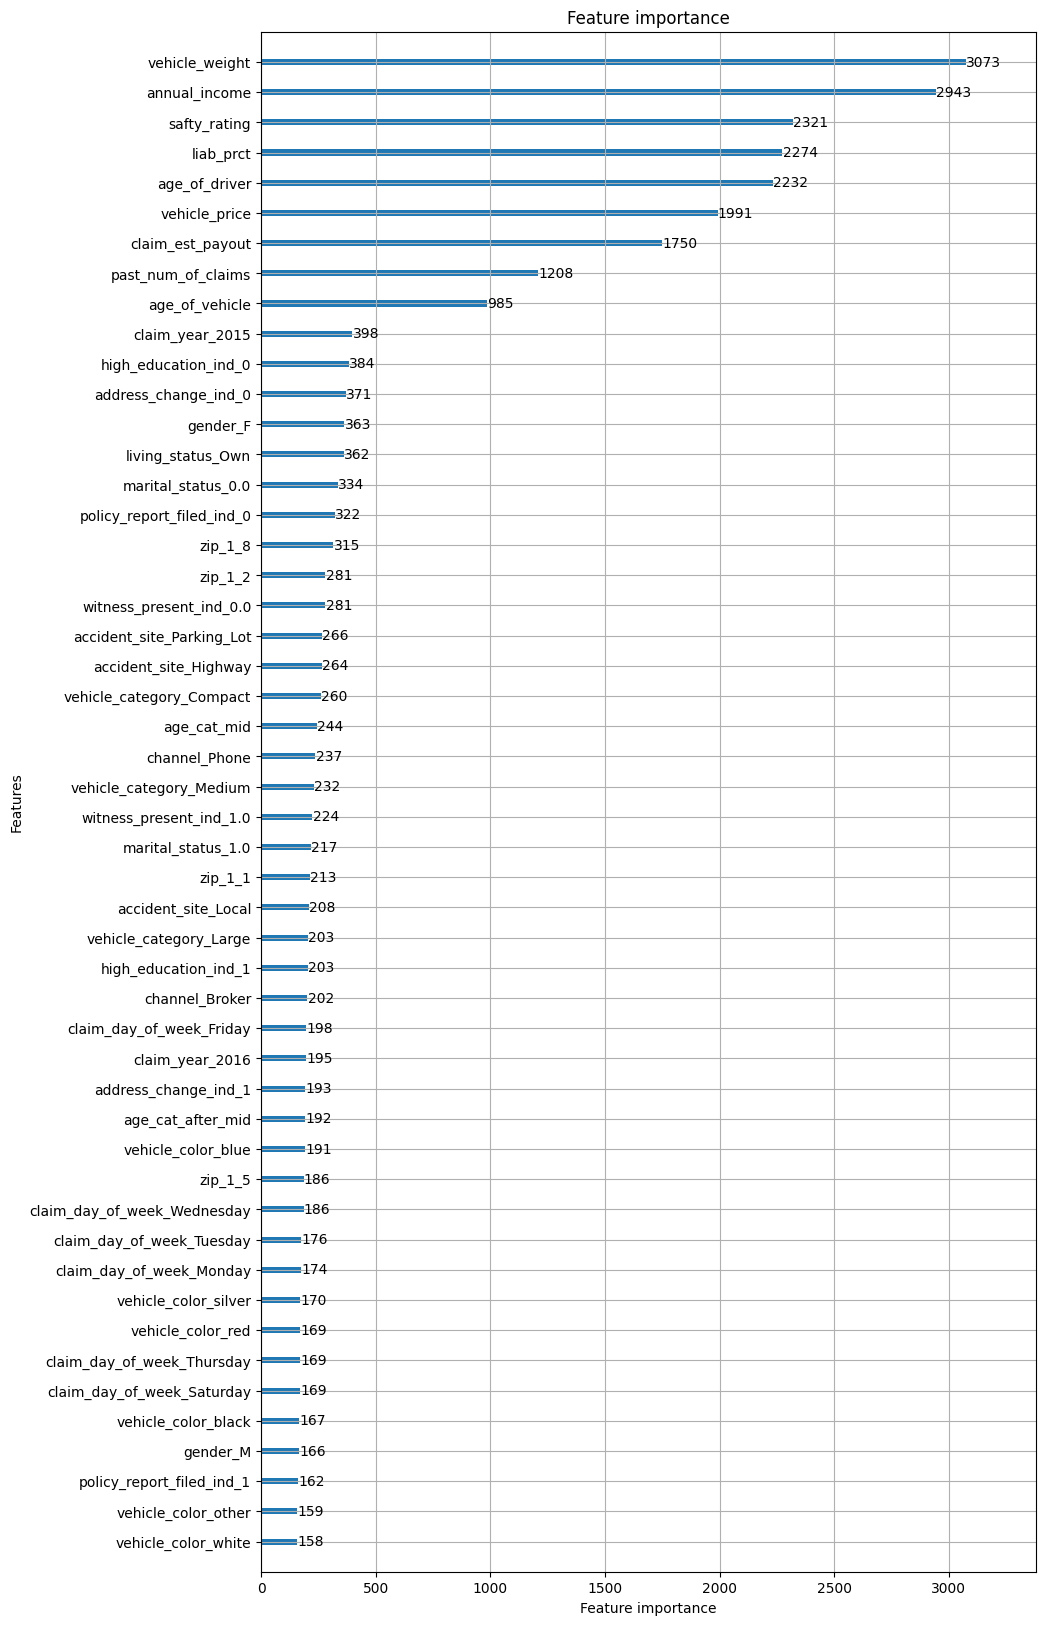

In [34]:
lgb.plot_importance(model_lgbm, max_num_features = 50)